# STA 141B Assignment 3

Due __Nov 10, 2023__ by __11:59pm__. Submit your work by uploading it to Gradescope through Canvas.

Please rename this file as __"LastName_FirstName_hw3"__ and export it as as pdf-file. 

The objective of this assignment is to solidify your understanding of programming fundamentals: defining functions, conditional statements, loops, and recursion. Subsequent assignments will delve deeper into data science topics.

Instructions:

1. Provide your solutions in new cells following each exercise description. Create as many new cells as necessary. Use code cells for your Python scripts and Markdown cells for explanatory text or answers to non-coding questions. Answer all textual questions in complete sentences.

2. Prioritize code readability. Just as in writing a book, the clarity of each line matters. Adopt the __one-statement-per-line__ rule. If you have a lengthy code statement, consider breaking it into multiple lines for clarity. (Please note: violating the one-statement-per-line rule will result in a one-point deduction for each offending line.)

3. To help understand and maintain code, you should always add comments to explain your code. Use the hash symbol (#) to start writing a comment (homework without any comments will automatically receive 0 points).

4. Submit your final work as a __.pdf__ file on __Gradescope__. To convert your .ipynb file into one of these formats, navigate to "File", select "Download as", and then choose either "PDF via LaTeX" or "HTML". If "PDF via LaTeX" does not work for you, export to "HTML", and then use Chrome to print the .html file into PDF. Gradescope only accepts PDF files.

5. This assignment will be graded on your proficiency in programming. Be sure to demonstrate your abilities and submit your own, correct and readable solutions. 

### Problem 1: Delphi’s Epidata API [2 Points]

In order to query a public API, it is important to carefully read the documentation. Consider Delphi’s Epidata API, which - amongst others - tracks and provides data about the Covid-19 disease. We are interested in querying from the COVIDcast Epidata API. 

#### Exercise

a) Make three requests, retrieving the signal `smoothed_wcli` and `smoothed_whh_cmnty_cli` from the `fb-survey` datasource as well as the `confirmed_7dav_incidence_prop` signal from the `jhu-csse` on `2022-01-01` for all states. Transform the response to `pandas.DataFrame`. 

b) Next, create a new table with three columns with the signals `smoothed_wcli`, `smoothed_whh_cmnty_cli` and `confirmed_7dav_incidence_prop`. Drop missing values and compute the sample correlation matrix.

<span style="color:#F00">Grading</span>
* 1.a
    * Write code for the procedure: - 0.25 incorrect/ -0.5 empty
    * conf_jhu.info() result: -0.25 incorrect / -0.5 missing
* 1.b
    * Pandas processing: -0.25 incorrect / -0.5 missing
    * Correlation result: -0.25 incorrect / -0.5 missing

In [1]:
# a)

import requests
import pandas as pd

def fetch(data_source, signal): 
    url = 'https://api.covidcast.cmu.edu/epidata/covidcast?' # endpoint from example in docs
    params = {'data_source': data_source,
             'signal': signal,
             'time_type': 'day',
             'geo_type': 'state',
             'time_values': '20220101',
             'geo_values': '*'}
    results = requests.get(url, params)
    table = pd.DataFrame(results.json()['epidata'])
    return(table)

scl_fb = fetch('fb-survey', 'smoothed_wcli')
shccl_fb = fetch('fb-survey', 'smoothed_whh_cmnty_cli')
conf_jhu = fetch('jhu-csse', 'confirmed_7dav_incidence_prop')

In [7]:
conf_jhu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   geo_value            56 non-null     object 
 1   signal               56 non-null     object 
 2   source               56 non-null     object 
 3   geo_type             56 non-null     object 
 4   time_type            56 non-null     object 
 5   time_value           56 non-null     int64  
 6   direction            0 non-null      object 
 7   issue                56 non-null     int64  
 8   lag                  56 non-null     int64  
 9   missing_value        56 non-null     int64  
 10  missing_stderr       56 non-null     int64  
 11  missing_sample_size  56 non-null     int64  
 12  value                56 non-null     float64
 13  stderr               0 non-null      object 
 14  sample_size          0 non-null      object 
dtypes: float64(1), int64(6), object(8)
memory 

In [8]:
# b)

# sort by geo value to join
scl_fb.set_index('geo_value', inplace=True)
shccl_fb.set_index('geo_value', inplace=True)
conf_jhu.set_index('geo_value', inplace=True)

# join to one data frame
df = conf_jhu.join(shccl_fb[['value']], rsuffix='_shccl_fb')
df = df.join(scl_fb[['value']], rsuffix='_scl_fb')

# reduce and rename columns in data frame
df = df[['value', 'value_shccl_fb', 'value_scl_fb']]
df.columns = ['value_conf_jhu', 'value_shccl_fb', 'value_scl_fb']

# drop missings
df = df.dropna()

df.corr()

,value_conf_jhu,value_shccl_fb,value_scl_fb
value_conf_jhu,1.000000,0.541672,0.458741
value_shccl_fb,0.541672,1.000000,0.788089
value_scl_fb,0.458741,0.788089,1.000000


### Problem 2: University of California Employee Pay [6 Points]

As a public organization, the compensations of employees of all institutions of the University of California are freely accessible. These reports cover UC's career faculty and staff employees, as well as part-time, temporary and student employees. It is accessible [here](https://ucannualwage.ucop.edu). Internally, the data requested by the search mask is queried using an undocumented API. We are interested to compare the gross pay to the number of units actually taught. To this end, we use the [UCD registry](https://registrar-apps.ucdavis.edu/courses/search/index.cfm). 

__Hint__: The University of California Employee Pay API returns an object that is not in json format, since it includes single instead of double quotation marks. Instead of the method `.json`, the data can be accessed using the function `json.loads` from the `json` module, after replacing the quotation marks: 

    result = requests. ... # this is the request
    import json
    json.loads(result.text.replace("\'", "\"")) # this returns a dict
    
Also, throughout this exercise, we will extracts digits from strings. This can be achieved using the `re` package: 

    import re
    re.findall('\d+', "this is a test 12 string with some 23, 0 digits in it!") # returns ['12', '23', '0']    

#### Exercise

a) Query the wage API to obtain the annual wage data of 2021 of all UC Davis professors. Remove all privaticed names and return a `pandas.DataFrame` with the first name, last name and gross pay, sorted in descending order. Print the first __six__ rows. The first three are: 

```
> wage_table.head(3)
	FirstName	LastName	Pay
1124	GRIFFITH	HARSH	1197167.0
1503	CHRISTOPHER	KREULEN	1174990.0
1136	BRIAN	HAUS	926743.0

```

b) Next, find out how many _units_ each person of this data frame has taught. To reduce effort, only consider the first 100 rows of `wage_table`. Query these employees in the UCD registry. If courses were taught, those will be displayed here. For example `KRAMLINGER` and `Fall Quarter 2023` gives six courses. Each has a link with additional information (e.g., `view 50589`). From there, additional information can be accessed. Here, we are interested in the value of __Units__, for all courses taught. 

Aggregate the units for all courses taught in all terms in 2021 for the 100 largest entries from a). Create a new data set, `full_table`, that contains these 100 largest entries from a) and the total units. Add another column that calculates the pay per unit and re-sort the vector. Print the first __six__ rows.

```
> full_table.head(3) 
	FirstName	LastName	Pay	Units	PayPerUnit
1749	RICHARD	MARDER	552965.0	3	184321.666667
299	RICHARD	BOLD	532720.0	5	106544.000000
1270	SAMUEL	HWANG	732169.0	8	91521.125000
```


<span style="color:#F00">Grading</span>

* a) Fetch wage data for UC Davis professors
    * API calling setup: 0.5 points
    * Function to fetch data: 1 points
    * Data processing with Pandas: 0.5 points
    * Final output (printing of top 6 rows): 1 points

* b) Fetch wage data for UC Davis professors
    * Function to fetch CRN: 0.5 points
    * Function to fetch units: 0.5 points
    * Threading for request: 0.5 points
    * Post-processing: 0.5 points
    * Final output (printing of top 6 rows): 1 points

In [6]:
# a) 

import json
import pandas as pd
import requests
import time

def fetch_wage_single_page(page):
    '''
    Queries a single page given the parameters. 
    '''
    result=requests.post('https://ucannualwage.ucop.edu/wage/search.action?', params = {
        '_search': 'false',
        'nd': '1666118385533',
        'rows': '1000', # uff, turns out that the API takes this... 
        'page': page,
        'sidx': 'EAW_LST_NAM',
        'sord': 'asc',
        'year': '2021',
        'location': 'Davis',
        'firstname': '',
        'lastname': '',
        'title': 'Prof',
        'startSal': '',
        'endSal': '',
    })
    result.raise_for_status()
    results = json.loads(result.text.replace("\'", "\""))
    return(results)

def fetch_wage_all_pages(): 
    '''
    Queries all pages given the parameters. 
    '''
    results = fetch_wage_single_page(1)
    total_pages = int(results['total']) #first get total number of pages to query
    
    wage = [x['cell'] for x in results['rows']] # return the results as list
    
    for page in range(2, total_pages + 1): 
        time.sleep(0.05)
        results = fetch_wage_single_page(page)
        wage.extend([x['cell'] for x in results['rows']])
    
    return(wage)

In [12]:
wage = fetch_wage_all_pages()
wage_table = pd.DataFrame(wage)[[3,4,6]]

wage_table.columns = ['FirstName', 'LastName', 'Pay'] # rename columns 
wage_table = wage_table.query("LastName != '*****'") # remove private data
wage_table['FirstName'] = list(map(lambda x: x.split()[0], wage_table['FirstName'])) # process first names
wage_table = wage_table.astype({'Pay':'float'})
wage_table = wage_table.sort_values(by = 'Pay', ascending = False)

wage_table.head(n = 6)

,FirstName,LastName,Pay
1124,GRIFFITH,HARSH,1197167.0
1503,CHRISTOPHER,KREULEN,1174990.0
1136,BRIAN,HAUS,926743.0
808,CHRISTOPHER,EVANS,912962.0
2261,ROBERT,RANDALL,909825.0
2321,ROLANDO,ROBERTO,901841.0


In [ ]:
# b) 

import re
import lxml.html as lx

def get_CRN(instructor, termCode): 
    url = "https://registrar-apps.ucdavis.edu/courses/search/course_search_results.cfm"
    data = {
        'termCode': termCode,
        'instructor': instructor
    }
    session = get_session()
    response = session.post(url, data = data)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    
    # we need to see if the instructor taught anything 
    if "No courses found with the following search parameters" in response.text: 
        return set()
    
    # strong selects the bold entries
    # the first two are not CRNs
    # 'set' makes CRNs unique
    table = [i.text_content() for i in html.xpath('//strong')]
    table = [re.findall('\d+', t) for t in table]
    table = set([t[0] for t in table if t != []])
    return table

In [ ]:
def get_units(crn, termCode): 
    url = "https://registrar-apps.ucdavis.edu/courses/search/course.cfm"
    data = {
        'crn': crn,
        'termCode': termCode
    }
    session = get_session()
    response = session.post(url, data = data)
    response.raise_for_status()
    html = lx.fromstring(response.text)
    
    table = [i.text_content() for i in html.xpath('//td')] # extract table contents

    #findall finds all digits 
    #in the in the table under section with characters "Units"
    #returns only list of one, so retrieve [0]'s entry
    units = [int(re.findall('\d+', t)[0]) for t in table if "Units" in t][0]
    return units

In [ ]:
def get_total_units(instructor): 
    # find the term codes using manual inspection
    termCodes = ['20210' + str(i) for i in range(10)]
    termCodes[0] = '202110'
    
    units = 0
    for termCode in termCodes: 
        CRN = get_CRN(instructor, termCode)
        units += sum([get_units(crn, termCode) for crn in CRN])
    
    return units

In [ ]:
# Use threading, as we are making 3000 requests

import concurrent.futures, threading
thread_local = threading.local() 

def get_all_units(names): 
    with concurrent.futures.ThreadPoolExecutor(10) as executor:
        units = executor.map(get_total_units, names)
    return(units)

def get_session():
    if not hasattr(thread_local, "session"): 
        thread_local.session = requests.Session()
    return thread_local.session

In [ ]:
names = wage_table['LastName'].iloc[0:100]
units = [int(i) for i in get_all_units(names)] # takes a while (2 minutes)

In [ ]:
full_table = wage_table.iloc[0:100, :]
full_table["Units"] = units
full_table = full_table[full_table['Units']!=0] # remove zero cases
full_table["PayPerUnit"] = full_table["Pay"] / full_table["Units"]
full_table = full_table.sort_values(by = 'PayPerUnit', ascending = False)
full_table.head(n = 6)

C:\Users\my\AppData\Local\Temp\ipykernel_2816\2986942827.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_table["Units"] = units


,FirstName,LastName,Pay,Units,PayPerUnit
1749,RICHARD,MARDER,552965.0,3,184321.666667
299,RICHARD,BOLD,532720.0,5,106544.000000
1270,SAMUEL,HWANG,732169.0,8,91521.125000
3034,THEODORE,WUN,535838.0,6,89306.333333
1555,PRIMO,LARA,591362.0,8,73920.250000
1348,JAYNE,JOO,537232.0,10,53723.200000


### Problem 3 : S&P 500 Market Cap [2 Points]

It is of great interest to infer about the behaviour of econometric time series. Here, we want to scrape the historical S&P 500 market capitalization that is publicly available at [ycharts](https://ycharts.com/indicators/sp_500_market_cap). We will be extracting the market capitalization data from Dec 2016 to Dec 2022 using the package `BeautifulSoup`. 

#### Exercise

a) Find the table that is displayed in your browser using the `find_all` method. Next, load the `BeautifulSoup` package and display the html for this table using 
`print(table_found.prettify())`, where `table_found` is the `BeautifulSoup` object corresponding to the table of interest.

__Hint:__ The first few lines after you type `print(table_found.prettify())` should looks like this:


    <table class="table">
     <thead>
      <tr>
       <th>
        Date
       </th>
       <th class="text-right">
        Value
       </th>
      </tr>
      ...

b) Find all of the table rows in this table that contain the market cap data from Dec 2016 to Dec 2022. Convert this into a `pandas.DataFrame` that contains a `date` variable and `market_cap` variable where `date` is a datetime object, and `market_cap` is a float. Plot this timeseries. The plot must have x-axis and y-axis and a title.

<span style="color:#F00">Grading</span>

* a) Fetch wage data for UC Davis professors
    * Final output: 1 points

* b) Fetch wage data for UC Davis professors
    * Final output: 1 points

In [4]:
# a) 
import requests
import lxml
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup

headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'}
req = requests.get('https://ycharts.com/indicators/sp_500_market_cap', headers = headers)

market_cap = BeautifulSoup(req.text,'lxml')
table_found = market_cap.find_all('table')[5]

print(table_found.prettify())

<table class="table">
 <thead>
  <tr>
   <th>
    Date
   </th>
   <th class="text-right">
    Value
   </th>
  </tr>
 </thead>
 <tbody>
  <tr>
   <td>
    September 30, 2023
   </td>
   <td class="text-right">
    35.94T
   </td>
  </tr>
  <tr>
   <td>
    June 30, 2023
   </td>
   <td class="text-right">
    37.16T
   </td>
  </tr>
  <tr>
   <td>
    March 31, 2023
   </td>
   <td class="text-right">
    34.34T
   </td>
  </tr>
  <tr>
   <td>
    December 31, 2022
   </td>
   <td class="text-right">
    32.13T
   </td>
  </tr>
  <tr>
   <td>
    September 30, 2022
   </td>
   <td class="text-right">
    30.12T
   </td>
  </tr>
  <tr>
   <td>
    June 30, 2022
   </td>
   <td class="text-right">
    31.90T
   </td>
  </tr>
  <tr>
   <td>
    March 31, 2022
   </td>
   <td class="text-right">
    38.29T
   </td>
  </tr>
  <tr>
   <td>
    December 31, 2021
   </td>
   <td class="text-right">
    40.36T
   </td>
  </tr>
  <tr>
   <td>
    September 30, 2021
   </td>
   <td class="text-r

<AxesSubplot:title={'center':'Market cap since Dec 2016'}, xlabel='date'>

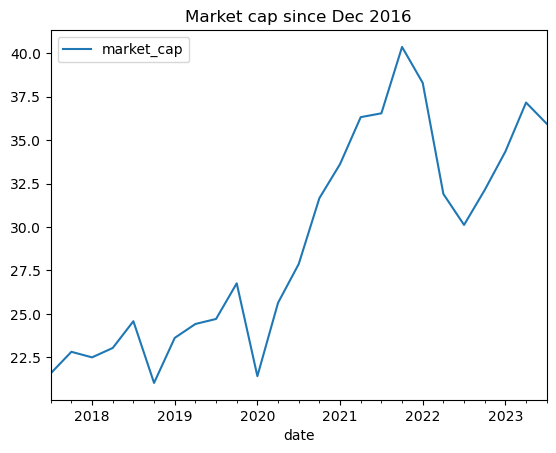

In [5]:
# b) 

tr_list = table_found.find_all('tr')

def proc_tr(tr_val):
    td_vals = tr_val.find_all('td')
    date_val = pd.Timestamp(td_vals[0].text)
    cap_val = float(td_vals[1].text.strip()[:-1])
    return {'date': date_val, 'market_cap': cap_val}

cap_data = pd.DataFrame(proc_tr(tr_val) for tr_val in tr_list[1:])

cap_data.plot('date','market_cap', title = 'Market cap since Dec 2016')